In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from collections import Counter
import sys

from utils import nice_tree_plot, niceprint, permute_square, invert_permutation, without_diag
from compute_pam import compute_combo_tensor_pam, IndividualNodeAlphaCalc
from example_graphs import make_tree
from sim_data import PAMSampler, topics_griffiths_steyvers
from lda_collapsed_gibbs import CollapsedGibbs
from tree_extraction import Aho
from tree_extraction.Aho import get_ratio_matrix
from alpha_extract import AlphaExtract
from param_stats import topic_difference, find_flat_permutation, find_structural_permutation

from end_to_end import Analysis

In [2]:
np.random.seed(1)

## Outline

1. Set up parameters of the model (tree structure, alphas, and topic definitions -- anything else?)
2. Compute "true" co-occurrence matrix
3. Generate some simulated data by sampling from the model
  - Parameters: Number of documents, distribution over document sizes
4. Compute "empirical" co-occurrence matrix (using known per-word-slot topic assignments).  Compare to "true" co-occurrence matrix.
5. Apply LDA or anchor words to the simulated data -- estimate topics and co-occurrence matrix.  Compare "estimated" co-occurrence matrix to "true" and "empirical" matrices.  Compare "estimated" topics to "true" topics.
  - Parameters: number of topics; any other parameters needed for the chosen topic-estimation algorithm
6. Compute ratio matrix
7. Derive triplet constraints from ratio matrix
8. Apply Aho's algorithm to constraints, producing a tree where each leaf corresponds to a topic.  Compare to "true" tree structure.
9. Extract alpha parameters from co-occurrence matrix.  Compare to "true" alpha parameters.
  - Parameters: $\alpha_{max}$ and $\delta_{min}$ corresponding to hypothesis class
  
TODO: Find a way to remove # of topics as a parameter (eg, measure perplexity, and loop over different of # topics)

In [3]:
branching_factors = [2, 2, 2]
num_true_topics = np.prod(branching_factors)  # number of topics with which to generate data

true_tree = make_tree(branching_factors)
index_to_leaf = [x for x in true_tree.nodes() if true_tree.out_degree(x) == 0]
leaf_to_index = {leaf: idx for idx, leaf in enumerate(index_to_leaf)}

In [4]:
# N = 10  # number of documents to generate
# M = 20  # number of words per document
# V = 25  # number of words in vocabulary
# dim = 5  # size of "square" to use in defining topics
# assert dim ** 2 == V

In [5]:
# N = 1000  # number of documents to generate
# M = 200  # number of words per document
# V = 100  # number of words in vocabulary
# dim = 10  # size of "square" to use in defining topics
# assert dim ** 2 == V

In [6]:
N = 5000  # number of documents to generate
M = 500  # number of words per document
V = 100  # number of words in vocabulary
dim = 10  # size of "square" to use in defining topics
assert dim ** 2 == V

In [7]:
true_topics = topics_griffiths_steyvers(num_topics = num_true_topics, dimension = dim)

In [8]:
true_alphas = {
    1: 1.5,
    2: 1.7,
    3: 1.9,
    4: 1.8,
    5: 2.0,
    6: 1.7,
    7: 1.6,
    8: 1.7,
    9: 1.8,
    10: 1.9,
    11: 1.4,
    12: 1.7,
    13: 1.5,
    14: 1.6,
}

In [9]:
# Main user-selected parameters for training & extraction
num_topics_to_train = num_true_topics
delta_min = 0.1
alpha_max = 10.0
custom_prior = 1.3 ** np.arange(len(index_to_leaf))[::-1]

In [10]:
# topic_extraction_strategy = "CollapsedGibbs"
# topic_extraction_params = dict(alpha = custom_prior)

In [11]:
topic_extraction_strategy = "AnchorWords"
topic_extraction_params = dict()

In [12]:
a = Analysis(
    # Data generation params:
    true_tree = true_tree,
    true_alphas = true_alphas,
    num_docs = N,
    words_per_doc = M,
    vocab_size = V,
    true_topics = true_topics,
    leaf_to_index = leaf_to_index,
    # Extraction params:
    num_topics_to_train = num_topics_to_train,
    delta_min = delta_min,
    alpha_max = alpha_max,
    topic_extraction_strategy = topic_extraction_strategy,
    topic_extraction_params = topic_extraction_params,
)

In [13]:
a.run();

100%|██████████| 5000/5000 [06:07<00:00, 13.61it/s]


Input matrix shape: (100, 5000)
identifying candidate anchors
100 candidates
Sum of entries in Q is  1.0000000000000258
Multiplying Q took  0.29434800148010254 seconds
Q sum is 1.0000000000000258
done reading documents
anchors are:
0 w26
1 w00
2 w81
3 w33
4 w62
5 w14
6 w90
7 w63
begin threaded recovery with 8 processors
0	-1	1.0
done recovering
w26 : w26 w24 w28 w29 w27 w25 w22 w23 w21 w20 
w00 : w00 w05 w06 w08 w07 w09 w04 w03 w01 w02 
w81 : w81 w51 w91 w71 w41 w61 w31 w01 w21 w11 
w33 : w33 w34 w39 w36 w37 w35 w38 w30 w32 w31 
w62 : w62 w52 w92 w72 w42 w82 w02 w32 w12 w22 
w14 : w14 w16 w17 w18 w15 w19 w11 w10 w12 w13 
w90 : w90 w60 w70 w80 w50 w40 w30 w20 w10 w36 
w63 : w63 w83 w43 w93 w73 w53 w03 w13 w23 w08 


## Display results

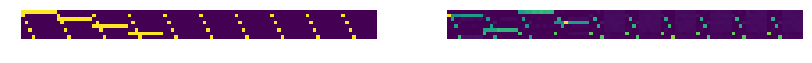

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(a.true_topics)
ax[0].axis('off')
ax[1].imshow(a.est_topics)
ax[1].axis('off')
None

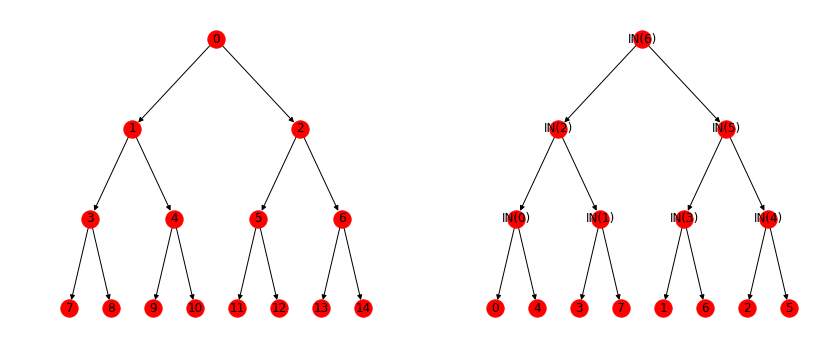

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
nice_tree_plot(a.true_tree, ax[0])
nice_tree_plot(a.est_tree, ax[1])

In [16]:
print(a.true_alphas)
print(a.est_alphas)

{1: 1.5, 2: 1.7, 3: 1.9, 4: 1.8, 5: 2.0, 6: 1.7, 7: 1.6, 8: 1.7, 9: 1.8, 10: 1.9, 11: 1.4, 12: 1.7, 13: 1.5, 14: 1.6}
{IN(2): -18.06098170538735, IN(0): 3.866954625909194, 0: 1.3768492014031912, 4: 1.7852583475487278, IN(1): 3.229518920539607, 3: 1.4836389511961725, 7: 1.4950193667589853, IN(5): -14.653267398847165, IN(3): 3.3064395463092002, 1: 1.4867265737606539, 6: 1.642448249157042, IN(4): 2.486219915026875, 2: 1.6182092733134412, 5: 1.2435311383562755}


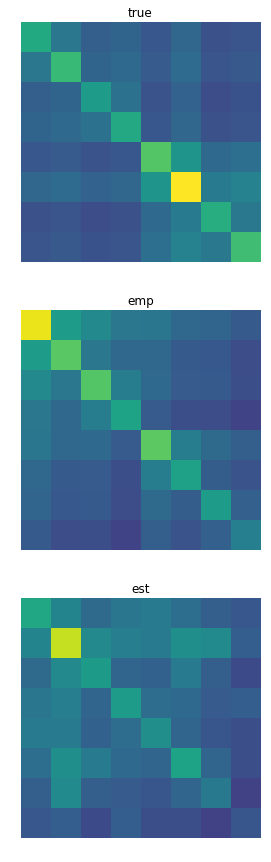

In [17]:
# Plot cooccurrence matrices
specs = [
    dict(name='true', cooccur=a.true_cooccur),
    dict(name='emp', cooccur=a.emp_cooccur),
    dict(name='est', cooccur=a.est_cooccur),
]

vmin=0.0
vmax=np.max([np.max(s["cooccur"]) for s in specs])

fig, ax = plt.subplots(len(specs), 1, figsize=(5, 5*len(specs)))
for i, spec in enumerate(specs):
    ax[i].imshow(spec["cooccur"], vmin=vmin, vmax=vmax)
    ax[i].axis('off')
    ax[i].set_title(spec["name"])

## Save results

In [18]:
a.save('results/results.pkl')

Saving to results/results_2019-05-08_at_01-22-54.pkl


## Find permutation that maps estimated topics to true topics

In [19]:
perm = find_flat_permutation(true_topics=a.true_topics, est_topics=a.est_topics)
perm

array([1, 6, 5, 2, 0, 4, 3, 7])

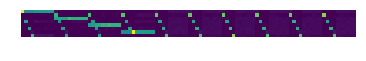

In [20]:
fig, ax = plt.subplots()
ax.imshow(a.est_topics[perm, :])
ax.axis('off')
None

In [21]:
est_cooccur_permuted = permute_square(X = a.est_cooccur, perm = perm)

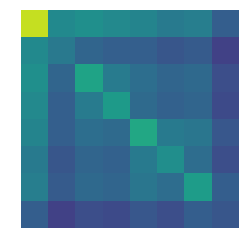

In [22]:
fig, ax = plt.subplots()
ax.imshow(est_cooccur_permuted, vmin=vmin, vmax=vmax)
ax.axis('off')
None

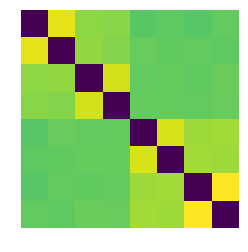

In [23]:
est_ratio_permuted = get_ratio_matrix(est_cooccur_permuted)

fig, ax = plt.subplots()
ax.imshow(without_diag(est_ratio_permuted))
ax.axis('off')
None

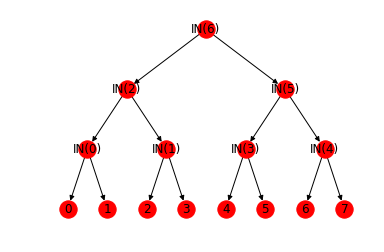

In [24]:
nice_tree_plot(Aho.extract(est_ratio_permuted, apply_ratio=False))

## Compare results of alpha extraction

0.0037849040316645793

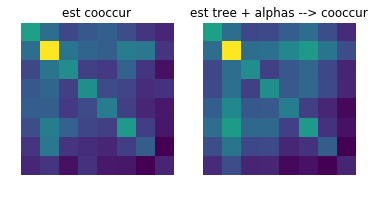

In [29]:
zzz = compute_combo_tensor_pam(a.est_tree, alpha=IndividualNodeAlphaCalc(a.est_tree, a.est_alphas))

fig, ax = plt.subplots(1, 2)

ax[0].imshow(a.est_cooccur)
ax[0].axis('off')
ax[0].set_title('est cooccur')

ax[1].imshow(zzz)
ax[1].axis('off')
ax[1].set_title('est tree + alphas --> cooccur')

np.max(np.abs(zzz - a.est_cooccur))

0.0007024377432287426

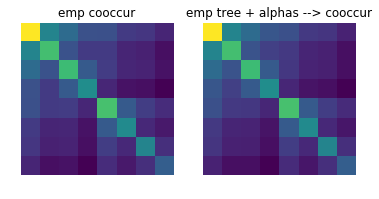

In [31]:
zzz = compute_combo_tensor_pam(a.emp_tree, alpha=IndividualNodeAlphaCalc(a.emp_tree, a.emp_alphas))

fig, ax = plt.subplots(1, 2)

ax[0].imshow(a.emp_cooccur)
ax[0].axis('off')
ax[0].set_title('emp cooccur')

ax[1].imshow(zzz)
ax[1].axis('off')
ax[1].set_title('emp tree + alphas --> cooccur')

np.max(np.abs(zzz - a.emp_cooccur))

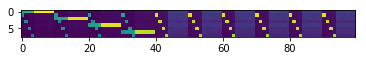

In [32]:
# Empirical estimate of topics
plt.imshow(a.emp_topics);

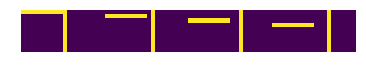

In [40]:
reshaped = np.hstack([x.reshape((dim, dim)) for x in a.true_topics])
fig, ax = plt.subplots()
ax.imshow(reshaped)
ax.axis('off')
None

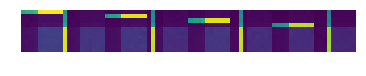

In [41]:
reshaped = np.hstack([x.reshape((dim, dim)) for x in a.emp_topics])
fig, ax = plt.subplots()
ax.imshow(reshaped)
ax.axis('off')
None

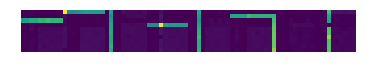

In [42]:
reshaped = np.hstack([x.reshape((dim, dim)) for x in a.est_topics])
fig, ax = plt.subplots()
ax.imshow(reshaped)
ax.axis('off')
None